# APPM 5720 Biweekly Report - Part 1
### *Alexey Yermakov*
### *November 10 2022*

# Summary
Since we are covering AutoML in class I decided to learn about Bayesian Optimization since I can use it in my research. There's a [good paper](https://arxiv.org/pdf/1807.02811.pdf) by Peter Frazier that reviews Bayesian Optimization methods up to 2018, when the paper was written. In this section I use a BO package I used in my research for training a ConvNN and optimizing the weight decay parameter of AdamW.

# Main Content

### What is Bayesian Optimization?

Bayesian Optimization (BO) is a method which can be used to tune hyperparameters of a machine learning. It works by having our training process available as a "black box" function whose input are our hyperparameters and the output is the minimum validation loss of our model with these hyperparameters. Bayesian Optimization then tests various inputs and uses the "black box" function evaluations to determine the next input to the black box function. After several iterations the method gives an estimate of the best hyperparameters to get the function to be a global minimum/maximum. In this report we'll focus on minimizing the validation loss of a machine learning model.

How does Bayesian Optimization know which hyperparameters to check when searching for a global minimum? Typically (and in this report) the latent function (which is synonymous with "black box" function) is modelled by a Gaussian Process: which is a statistical representation of what we thing the true function looks like. This Gaussian Process needs to have a mean function and a standard deviation function. Lets use a figure to explain this idea better:

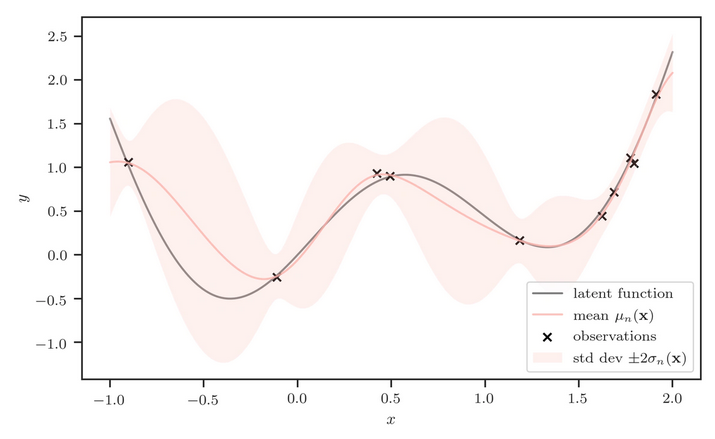

(figure from [here](https://tiao.io/post/an-illustrated-guide-to-the-knowledge-gradient-acquisition-function/))

In the above, we have the latent function in black as a function of x. We can think of x as a single hyperparameter we're trying to optimize in our machine learning model. In almost every situation where we're using Bayesian Optimization we will not know the true latent function values, since otherwise we could just determine the global minimum and call it a day. The figure has the latent function for demonstrative purposes. The figure also has black "x" marks. These "x" marks are results of our "black box" model at specific x-values. The Gaussian Process then uses these observations to build a statistical model of what we think the latent function looks like. We can see this via the mean (red line) with standard deviation around it (light red). As we can see, where the observations are closer together, we can be more confident of what the true latent function looks like by having a smaller standard deviation than in places where there is a large standard deviation.

So, once we've build a model of our latent function, we need to figure out how to determine which hyperparameter values to check next to find the global minimum. Typically this is done with something called an "acquisition function" which takes in the Gaussian Process and outputs the next point to check. Below we can see what this acquisition function can look like:

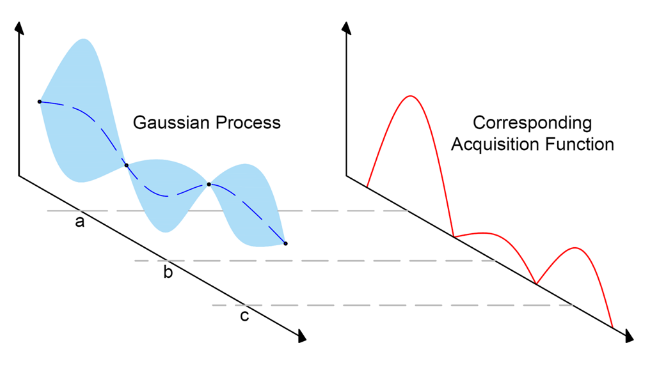

(figure from [here](https://doi.org/10.1007/s00138-020-01087-0))

Note that the above figure shows the acquisition function for a Gaussian Process trying to find a global maximum. As such, the acquisition function assigns a high value in places where the Gaussian Process has both a high mean and a high standard deviation value. Once another hyperparameter is chosen to be tested, it is passed into the "black box" function and the Gaussian Process updates its model based on this observation:

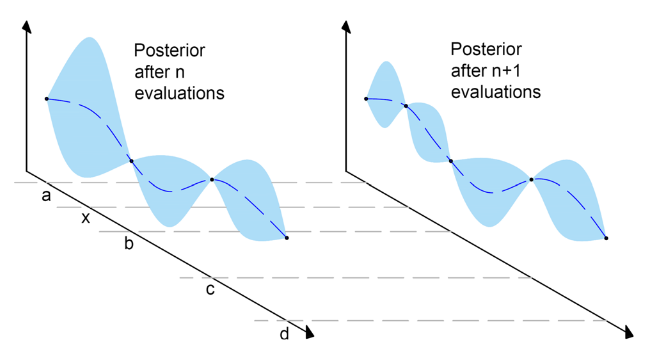

(figure from [here](https://doi.org/10.1007/s00138-020-01087-0))

Great! So you should have an idea of how Bayesian Optimization works at a high level. There are several other considerations that need to be taken into account that I'll cover in this report. However, if the basics don't make sense, here are a few more references to look at:

- [Bayesian Optimization Concept Explained in Layman Terms](https://towardsdatascience.com/bayesian-optimization-concept-explained-in-layman-terms-1d2bcdeaf12f)
- [A Conceptual Explanation of Bayesian Hyperparameter Optimization for Machine Learning](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)
- [A Tutorial on Bayesian Optimization](https://arxiv.org/pdf/1807.02811.pdf)

### Code

I'll be using [this](https://github.com/fmfn/BayesianOptimization) Bayesian Optimization package in this report. I picked it since it seems active and well-maintained. The README in the package also has some more visuals and what-not if you're interested! In this report I'll primarily be tuning the weight decay parameter in [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) since it'll allow me to produce nice figures (since I'm optimizing one parameter). I'll call this parameter lambda. I'll also be using a convolutional neural network from my last report on the FashionMNIST dataset (so that I can train the model relatively quickly).

For simplicity, I will be using my own Bayesian Optimization wrapper class for easier testing of different parameters used in Bayesian Optimization:

In [1]:
# Imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import warnings
from tabulate import tabulate
import numpy as np
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

# Print matplotlibe plots inline
%matplotlib inline

In [2]:
class BayesOptGeneral:
    '''
    `BayesOptGeneral`

    Bayesian Optimization wrapper class for easier testing
    '''

    def __init__(self, black_box, min_lambda, max_lambda, **kwargs):
        ##############
        # Parameters #
        ##############
        # Strictly required parameters
        self.black_box_function = black_box # Black box function
        self.min_lambda = min_lambda # Minimum lambda value
        self.max_lambda = max_lambda # Maximum lambda value

        # Optional parameters (they have defaults)

        # Set up utility function, currently using defaults from
        # https://github.com/fmfn/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py
        self.kind = kwargs.get("kind", 'ucb')
        self.kappa = kwargs.get("kappa", 2.576)
        self.xi = kwargs.get("xi", 0.0)
        self.kappa_decay = kwargs.get("kappa_decay", 1)
        self.kappa_decay_delay = kwargs.get("kappa_decay_delay", 0)
        self.init_points = kwargs.get("init_points", 10)
        self.n_iter = kwargs.get("n_iter", 20)
        self.alpha = kwargs.get("alpha", 0.2)

        self.np_seed = kwargs.get("np_seed", 41)
        self.bo_seed = kwargs.get("bo_seed", 41)

        # Constant seed for reproducability
        np.random.seed(self.np_seed)

        print("Bayesian Optimization Parameters:")
        self.print_params()
        print()

    def print_params(self):
        '''
        `print_params`
        
        Make a nice table of all the parameters of the class
        '''

        dict_tmp = dict()
        dict_tmp["Option"] = [
            "np_seed",
            "bo_seed",
            "min_lambda",
            "max_lambda",
            "kind",
            "kappa",
            "xi",
            "kappa_decay",
            "kappa_decay_delay",
            "init_points",
            "n_iter",
            "alpha"
        ]
        dict_tmp["Description"] = [
            self.np_seed,
            self.bo_seed,
            f"{self.min_lambda:0.2e}",
            f"{self.max_lambda:0.2e}",
            self.kind,
            self.kappa,
            self.xi,
            self.kappa_decay,
            self.kappa_decay_delay,
            self.init_points,
            self.n_iter,
            self.alpha
        ]
        print(tabulate(dict_tmp, headers="keys", tablefmt="pretty"))

    def extract_results(self, res):
        '''
        `extract_results`

        Given `optimizer` (res), extract the lists for `_lambda` and `target` that were evaluated
 
        Returns (`_lambda`: list, `target`: list)
        '''

        l_list = list()
        t_list = list()

        for elem in res:
            l_list += [elem['params']['_lambda']]
            t_list += [elem['target']]
        
        return (l_list, t_list)
    
    def posterior_mean_and_next_guess(self, optimizer, l_list, t_list, util):
        '''
        `posterior_mean_and_next_guess`

        Return GP mean and next evaluation from GP object from BO package
        '''
        # Generate some points to plot for BO
        lambda_eval = np.linspace(self.min_lambda, self.max_lambda, 100)
        # Add our evaluated lambdas to the list in order
        lambda_eval = np.sort(np.concatenate([lambda_eval, l_list]))

        # Given our lambdas and evaluations, git our gaussian process to the data
        # (Sklearn's GP throws a large number of warnings at times, but
        # we don't really need to see them here.)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            optimizer._gp.fit(np.vstack(l_list), np.vstack(np.asarray(t_list)))
        
        # For some reason return_std=True makes this output nothing
        # Get mean line for gaussian process
        GP_mean = optimizer._gp.predict(lambda_eval.reshape(-1,1)) # Obtain what we think the mean is

        # Get next guess
        new_pt = optimizer.suggest(util)['_lambda']

        # Get next point prediction
        next_pt = (new_pt, self.black_box_function(new_pt))

        return lambda_eval, GP_mean, next_pt

    def run(self):
        '''
        run

        Main code block of this class
        '''
        #########################
        # Bayesian Optimization #
        #########################

        # Set up bounds to pass in
        pbounds = {'_lambda': (self.min_lambda, self.max_lambda)}

        # Define our utility function and its parameters
        util = UtilityFunction(kind=self.kind,
                               kappa=self.kappa,
                               xi=self.xi,
                               kappa_decay=self.kappa_decay,
                               kappa_decay_delay=self.kappa_decay_delay)

        # Define the BO class
        optimizer = BayesianOptimization(
            f = self.black_box_function,
            pbounds=pbounds,
            random_state=self.bo_seed,
        )
  
        # Run BO
        # Check our guesses then run BO for a n_iter more lambda
        # NOTE: We're using default values from our utility here as well
        optimizer.maximize(
            init_points=self.init_points,
            n_iter=self.n_iter,
            alpha=self.alpha,
            acq=self.kind,
            kappa=self.kappa,
            xi=self.xi,
            kappa_decay=self.kappa_decay,
            kappa_decay_delay=self.kappa_decay_delay,
        )

        # Get our final lists of targets and guesses
        l_list, t_list = self.extract_results(optimizer.res)

        # Get mean and next point prediction
        lambda_eval, GP_mean, next_pt = self.posterior_mean_and_next_guess(optimizer, l_list, t_list, util)

        return l_list, t_list, lambda_eval, GP_mean, next_pt


Lets define our convolutional neural network now:

In [3]:
# Create our model
class ConvNN(nn.Module):
    def __init__(self):
        # See https://realpython.com/python-super/
        super(ConvNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=4,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=4,out_channels=8,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,padding='same'),
            nn.ReLU(inplace=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(
            nn.Linear(16 * 6 * 6, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 10),
        )

        
        # Define labels
        self.labels = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot"
        ]

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        
    def get_label(self, logits):
        pred_prob = nn.Softmax(dim=1)(logits)
        y_pred = pred_prob.argmax(1)
        return y_pred

Now lets make a class which takes in various parameters we can play with and spits out figures from the BO process on our convolutional neural network:

In [4]:
class MNISTReg:
    '''
    `MNISTReg`

    A simple example of training a ConvNN with FashionMNIST and regularization
    '''

    def __init__(self, **kwargs):
        '''
        `__init__`
        
        Initialize the MNISTReg class
        '''

        ##############
        # Parameters #
        ##############

        # Store input to pass into BO
        self.input = kwargs

        self.np_seed = kwargs.get("np_seed", 41)
        self.bo_seed = kwargs.get("bo_seed", 41)

        self.learning_rate = kwargs.get("learning_rate", 1e-3)
        self.epochs = kwargs.get("epochs", 3)
        self.verbose = kwargs.get("verbose", 0)
        self.batch_size = kwargs.get("batch_size", 32)
        self.mnist_dir = kwargs.get("mnist_dir", '/home/alexey/Datasets/')

        self.min_lambda = kwargs.get("min_lambda", 1e-3)
        self.max_lambda = kwargs.get("max_lambda", 1)
        self.y_to_aug = kwargs.get("y_to_aug", lambda y: y)
        self.y_from_aug = kwargs.get("y_from_aug", lambda y: y)
        self.x_to_aug = kwargs.get("x_to_aug", lambda x: x)
        self.x_from_aug = kwargs.get("x_from_aug", lambda x: x)

        # BO Parameters
        self.kind = kwargs.get("kind", 'ucb')
        self.kappa = kwargs.get("kappa", 2.576)
        self.xi = kwargs.get("xi", 0.0)
        self.kappa_decay = kwargs.get("kappa_decay", 1)
        self.kappa_decay_delay = kwargs.get("kappa_decay_delay", 0)
        self.init_points = kwargs.get("init_points", 10)
        self.n_iter = kwargs.get("n_iter", 20)
        self.alpha = kwargs.get("alpha", 0.2)


        # Optional figure parameters
        self.save_bo_fig = kwargs.get("save_bo_fig", False)
        self.bo_fig_name = kwargs.get("bo_fig_name", "PLOT")
        self.save_train_fig = kwargs.get("save_train_fig", False)
        self.train_fig_name = kwargs.get("train_fig_name", "MNIST")

        ##################
        # Initialization #
        ##################

        # Check if GPU is being used
        if self.verbose == 1:
            print("GPU Available?",torch.cuda.is_available())

        self.device = "cpu"
        if torch.cuda.is_available():
            self.device = "cuda"

        # Count the number of models trained
        self.count = 0
        
        print("MNISTReg Parameters:")
        self.print_params()

    def print_params(self):
        '''
        `print_params`
        
        Make a nice table of all the parameters of the class
        '''

        dict_tmp = dict()
        dict_tmp["Option"] = [
            "np_seed",
            "bo_seed",
            "learning_rate",
            "epochs",
            "verbose",
            "batch_size",
            "mnist_dir",
            "min_lambda",
            "max_lambda",
            "kind",
            "kappa",
            "xi",
            "kappa_decay",
            "kappa_decay_delay",
            "init_points",
            "n_iter",
            "alpha",
            "save_bo_fig",
            "bo_fig_name",
            "save_train_fig",
            "train_fig_name"
        ]
        dict_tmp["Description"] = [
            self.np_seed,
            self.bo_seed,
            self.learning_rate,
            self.epochs,
            self.verbose,
            self.batch_size,
            self.mnist_dir,
            f"{self.min_lambda:0.2e}",
            f"{self.max_lambda:0.2e}",
            self.kind,
            self.kappa,
            self.xi,
            self.kappa_decay,
            self.kappa_decay_delay,
            self.init_points,
            self.n_iter,
            self.alpha,
            self.save_bo_fig,
            self.bo_fig_name,
            self.save_train_fig,
            self.train_fig_name
        ]
        print(tabulate(dict_tmp, headers="keys", tablefmt="pretty"))

    def create_data_loaders(self):
        '''
        `create_data_loaders`

        Load our FashionMNIST dataset and return the training and testing dataloader
        '''
        # Load dataset
        train_data = datasets.FashionMNIST(
            root=self.mnist_dir,
            train=True,
            download=True,
            transform=ToTensor()
        )
        test_data = datasets.FashionMNIST(
            root=self.mnist_dir,
            train=False,
            download=True,
            transform=ToTensor()
        )

        # Create data loaders with class batch size
        train_dl = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        test_dl = DataLoader(test_data, batch_size=self.batch_size, shuffle=True)

        if self.verbose == 1:
            train_sz = len(train_dl)
            test_sz = len(test_dl)
            total_sz = train_sz + test_sz
            print(f"Training data size: {train_sz} ({train_sz/total_sz*100:02.2f}%)")
            print(f"Testing data size: {test_sz} ({test_sz/total_sz*100:02.2f}%)")

        # Define our preprocessing function for images and labels from a batch
        def preprocess(x, y):
            return x.to(self.device), y.to(self.device)
        
        # Create our own data loader with preprocessing
        class WrappedDataLoader:
            def __init__(self, dl, func):
                self.dl = dl
                self.func = func

            def __len__(self):
                return len(self.dl)

            def __iter__(self):
                batches = iter(self.dl)
                for b in batches:
                    # *b makes it so that the input to func is two variables: the images and the labels
                    # yield is like return except it stops execution until the object is "grabbed"
                    yield (self.func(*b)) 
        
        train_dl2 = WrappedDataLoader(train_dl, preprocess)
        test_dl2 = WrappedDataLoader(test_dl, preprocess)

        return train_dl2, test_dl2

    def train_loop(self, dataloader, model, loss_fn, optimizer):
        '''
        `train_loop`

        Train our model for one epoch, return loss and accuracy
        '''
        size = len(dataloader)*self.batch_size
        for batch, (X, y) in enumerate(dataloader):
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y) 

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if self.verbose == 1 and batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    def get_acc(self, dataloader, model, loss_fn, print_str, print_override = False):
        '''
        `get_acc`

        Get the accuracy of our model on a specific dataset
        '''
        size = len(dataloader)*self.batch_size
        num_batches = len(dataloader)
        test_loss, correct = 0, 0

        with torch.no_grad():
            for X, y in dataloader:
                pred = model(X)
                loss = loss_fn(pred, y)

                test_loss += loss.item()

                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size

        if self.verbose == 1 or print_override:
            print(f"{print_str}: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
        return test_loss, 100*correct

    def get_opt(self, model, _lambda):
        '''
        `get_opt`

        The optimization function we're using
        '''
        return torch.optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=_lambda)

    def get_loss(self):
        '''
        `get_loss`

        The loss function we're using
        '''
        return nn.CrossEntropyLoss()

    def get_min(self, x, y):
        '''
        `get_min`

        Given a list of x and y values, return the  minimum y with x: (x,y)
        '''
        min = (x[0], y[0])
        for val in list(zip(x,y)):
            min = min if min[1] < val[1] else val
        return min

    def get_max(self, x, y):
        '''
        `get_max`

        Given a list of x and y values, return the  maximum y with x: (x,y)
        '''
        max = (x[0], y[0])
        for val in list(zip(x,y)):
            max = max if max[1] < val[1] else val
        return max

    def black_box_function(self, _lambda):
        '''
        `black_box_function`

        Train this model from scratch and return the lowest loss
        '''

        _lambda = self.x_from_aug(_lambda)

        # Increment count
        self.count += 1

        # Create our model
        model = ConvNN().to(self.device)

        # Create our dataset
        train_dl, test_dl = self.create_data_loaders()

        # Get our optimizer and loss function
        opt_fn, loss_fn = self.get_opt(model, _lambda), self.get_loss()

        # Save training and testing accuracy
        train_loss = list(); train_acc = list()
        test_loss = list(); test_acc = list()

        # Perform the training process
        for t in range(self.epochs):
            # Run training loop
            if self.verbose == 1:
                print(f"Epoch {t+1}\n---------------------------------")
            self.train_loop(train_dl, model, loss_fn, opt_fn)

            # Get losses
            loss, acc = self.get_acc(train_dl, model, loss_fn, "Train Error")
            train_loss += [loss]
            train_acc += [acc]
            if self.verbose == 1:
                print()

            loss, acc = self.get_acc(test_dl, model, loss_fn, "Test Error")
            test_loss += [loss]
            test_acc += [acc]
            if self.verbose == 1:
                print()
        
        if self.verbose == 1:
            print("Done!")

            print("Training accuracy:")
            print(np.vstack(np.asarray(train_acc)))
            print()

            print("Training loss:")
            print(np.vstack(np.asarray(train_loss)))
            print()

            print("Testing accuracy:")
            print(np.vstack(np.asarray(test_acc)))
            print()

            print("Testing loss:")
            print(np.vstack(np.asarray(test_loss)))
            print()

        file_name = f"{self.count}_{self.train_fig_name}_{_lambda:.4f}.pdf"
        plot_train_test_acc_loss(train_acc, test_acc, train_loss, test_loss, save_plot=self.save_train_fig, file_name=file_name, _lambda=_lambda)

        # Return latest test loss augmented
        if self.verbose == 1:
            print(f"Final loss for _lambda {_lambda}: {test_loss[-1]}")
            print("Returning", self.y_to_aug(test_loss[-1]))
        return self.y_to_aug(test_loss[-1])

    def convert_plotting_data(self, l_list, t_list, lambda_eval, GP_mean, actual_pt):
        '''
        `convert_plotting_data`

        Converts Bayesian Optimization output back to real values via our defined transformatoins
        '''
        l_list = self.x_from_aug(np.asarray(l_list))
        t_list = self.y_from_aug(np.asarray(t_list))
        lambda_eval = self.x_from_aug(np.asarray(lambda_eval))
        GP_mean = self.y_from_aug(np.asarray(GP_mean))
        actual_pt = (self.x_from_aug(actual_pt[0]), self.y_from_aug(actual_pt[1]))
        return l_list, t_list, lambda_eval, GP_mean, actual_pt

    def run(self):
        '''
        `run`

        The main code to train our model and get accuracies
        '''

        ##############################
        # Call Bayesian Optimization #
        ##############################

        # Convert lambda based on x-axis transformation
        min_lambda = self.x_to_aug(self.min_lambda)
        max_lambda = self.x_to_aug(self.max_lambda)

        # Update input that we're passing to BO
        input = self.input
        input["min_lambda"] = min_lambda
        input["max_lambda"] = max_lambda

        # Run BO and save output
        bog = BayesOptGeneral(self.black_box_function, **self.input)
        l_list, t_list, lambda_eval, GP_mean, actual_pt = bog.run()

        ##############################
        # Plot and Print Useful Data #
        ##############################

        # Convert our output from BO back to real values (via our transformations)
        l_list, t_list, lambda_eval, GP_mean, actual_pt = self.convert_plotting_data(l_list, t_list, lambda_eval,\
            GP_mean, actual_pt)

        # Get true error and the minimum of it
        best_GP = self.get_min(l_list, t_list)

        # Make our plot
        plot_bayes_concept(l_list, t_list, None, None, lambda_eval, GP_mean,\
            actual_pt, best_GP, self.save_bo_fig, self.bo_fig_name)


And lastly, lets define our plotting functions:

In [5]:
def plot_bayes_concept(l_list, t_list, err_true, min_true, lambda_eval, GP_mean, next_pt, best_GP, save_fig = False, fig_name = "PLOT"):
    '''
    plot_bayes_concept

    Make a plot of data resulting from BayesOpt(...) in bayes_opt_concept.py
    '''
    fig, ax = plt.subplots(1,1,figsize=(5,5), dpi=120, facecolor='white', tight_layout={'pad': 1})

    marker_style = dict(markersize = 10, markeredgecolor='black')

    data_marker_size = 2
    min_marker_style = '*'

    if err_true is not None:
        ax.plot(lambda_eval, err_true, linestyle='solid', marker='^', markersize=data_marker_size, color='#d95319', label="True Risk")
    if min_true is not None:
        ax.plot(min_true[0], min_true[1], marker=min_marker_style, color='red', label="True Risk Minimum", **marker_style)
    ax.plot(l_list, t_list, linestyle='none', marker='*', color='green', label="Batch Risk", **marker_style)
    ax.plot(next_pt[0], next_pt[1], linestyle='none', marker='*', color='yellow', label="Next Point", **marker_style)
    ax.plot(best_GP[0], best_GP[1], linestyle='none', marker='*', color='#0088FF', label="BO Best", **marker_style)
    ax.plot(lambda_eval, GP_mean, linestyle='solid', marker='.', markersize=data_marker_size, color='blue', label="Posterior Mean")

    ax.set_xlabel('Regularization $\lambda$')
    ax.set_ylabel('Risk')

    ax.loglog()
    ax.legend(fontsize='small')

    if save_fig:
        plt.savefig(f'./Images/{fig_name}.pdf')
        plt.close()
    else:
        plt.show()
        
def plot_train_test_acc_loss(train_acc, test_acc, train_loss, test_loss, file_name = "PLOT",\
                            save_plot=False, _lambda=None):
    '''
    plot_train_test_acc

    Make a plot of training vs testing accuracy
    '''

    # Make plot
    fig, ax = plt.subplots(1,2,figsize=(10,5), dpi=120, facecolor='white', tight_layout={'pad': 1})

    marker_style = dict(markersize = 6)

    ax[0].plot(list(range(1, len(train_acc)+1)), train_acc, linestyle='solid', marker='^', color='#d95319', label="Training Accuracy", **marker_style)
    ax[0].plot(list(range(1, len(test_acc)+1)), test_acc, linestyle='solid', marker='^', color='#0072bd', label="Testing Accuracy", **marker_style)

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    ax[0].legend(fontsize='small')

    ax[0].set_title(f"$lambda$: {_lambda:1.4e}")

    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1].plot(list(range(1, len(train_loss)+1)), train_loss, linestyle='solid', marker='^', color='#d95319', label="Training Loss", **marker_style)
    ax[1].plot(list(range(1, len(test_loss)+1)), test_loss, linestyle='solid', marker='^', color='#0072bd', label="Testing Loss", **marker_style)

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')

    ax[1].legend(fontsize='small')

    if _lambda is not None:
        ax[1].set_title(f"$\lambda$: {_lambda:1.4e}")

    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    if save_plot == True:
        plt.savefig(f'./Images/{file_name}.pdf')
        plt.close()
    else:
        plt.show()

In [6]:
# Transformations
y_to_aug = lambda y: -1*y
y_from_aug = lambda y: -1*y
x_to_aug = lambda x: np.log10(x)
x_from_aug = lambda x: 10**x

# Input
input = {
    # Shared parameters
    'np_seed': 41,
    'bo_seed': 13,

    # Concept parameters
    'learning_rate': 0.001,
    'epochs': 150,
    'verbose': 0,
    'batch_size': 32,
    'mnist_dir': '/home/alexey/datasets',
    'y_to_aug': y_to_aug,
    'y_from_aug': y_from_aug,
    'x_to_aug': x_to_aug,
    'x_from_aug': x_from_aug,

    # BO Parameters
    'min_lambda': 1e-10,
    'max_lambda': 1,
    'kind': 'ucb',
    'kappa': 2.576,
    'xi': 0.0,
    'kappa_decay': 1,
    'kappa_decay_delay': 0,
    'init_points': 10,
    'n_iter': 30,
    'alpha': 0.3,

    # Plotting parameters
    'save_bo_fig': True,
    'bo_fig_name': "BO_Result",
    'save_train_fig': True,
    'train_fig_name': "MNIST", # Names are of the format f'{count}_{train_fig_name}_{lambda}'
}

# MNIST Regression
st = MNISTReg(**input)
st.run()

MNISTReg Parameters:
+-------------------+-----------------------+
|      Option       |      Description      |
+-------------------+-----------------------+
|      np_seed      |          41           |
|      bo_seed      |          13           |
|   learning_rate   |         0.001         |
|      epochs       |          150          |
|      verbose      |           0           |
|    batch_size     |          32           |
|     mnist_dir     | /home/alexey/datasets |
|    min_lambda     |       1.00e-10        |
|    max_lambda     |       1.00e+00        |
|       kind        |          ucb          |
|       kappa       |         2.576         |
|        xi         |          0.0          |
|    kappa_decay    |           1           |
| kappa_decay_delay |           0           |
|    init_points    |          10           |
|      n_iter       |          30           |
|       alpha       |          0.3          |
|    save_bo_fig    |         True          |
|    bo_fig_n

Cool! Let's see what our GP looks like after our training process (which took 2 days...)

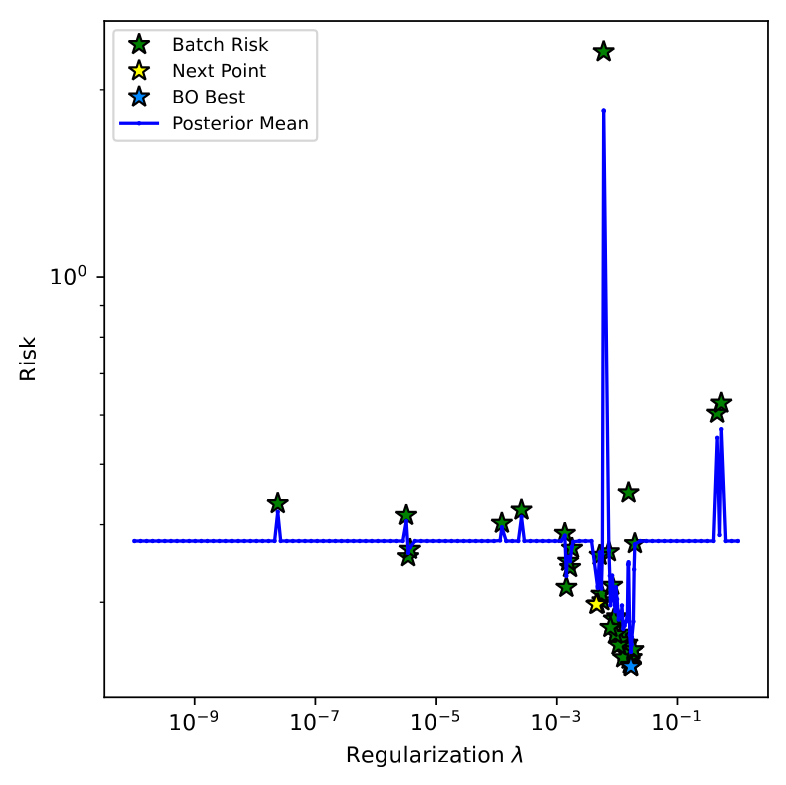

Poop! This is pretty bad since the posterior mean doesn't look very useful (mostly constant). I came across similar problems in my research where the GP doesn't look very good depending on the hyperparameters for BO. I won't try different parameters since it takes 2 days to train and I don't have time for trial and error.

Lets see what the training accuracy and loss look like for one of the above values for lambda just because I have that data now:

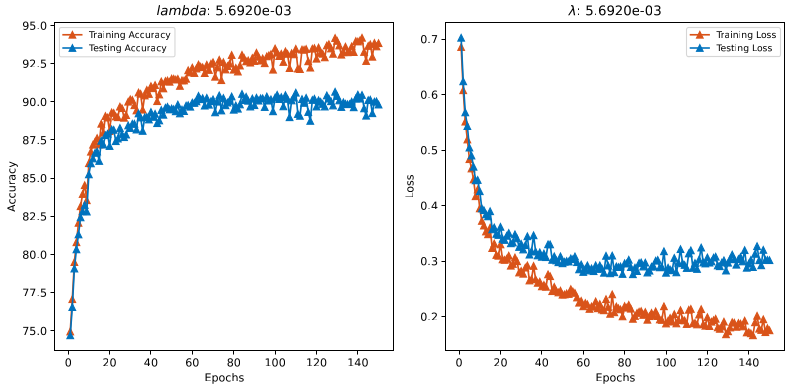

Cool!

I will now try a different BO package in part 2 of this report on a simple function.